In [ ]:
from google.colab import drive
drive.flush_and_unmount()
drive.mount('/content/drive', force_remount=True)

Drive not mounted, so nothing to flush and unmount.
Mounted at /content/drive


In [ ]:
!pip install nnUNetv2
!pip install timm
!pip install torch
!pip install torchvision

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 197.0/197.0 kB 13.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.7/61.7 kB 5.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 80.1 MB/s eta 0:00:00


- Preprocessing has been done in the CNN model
- Set different environment variables

In [ ]:
import os

os.environ['nnUNet_raw'] = '/content/drive/My Drive/MLQuiz-WangLab/nnUNet/nnUNet_raw/'
os.environ['nnUNet_preprocessed'] = '/content/drive/My Drive/MLQuiz-WangLab/nnUNet/nnUNet_preprocessed'
os.environ['nnUNet_results'] = '/content/drive/My Drive/MLQuiz-WangLab/nnUNet/nnUNet_transformer_results'

- Overwrite `build_network_architecture` function to incorporate nnU-Net model with transformer architecture

In [ ]:
import torch
import torch.nn as nn
from transformers import ViTModel

class CustomViTUNet(nn.Module):
    def __init__(self, vit_model_name='google/vit-base-patch16-224', num_output_channels=3):
        super(CustomViTUNet, self).__init__()
        self.vit = ViTModel.from_pretrained(vit_model_name)

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(768, 384, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(384, 192, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(192, 96, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(96, num_output_channels, kernel_size=1)
        )
        print("CustomViTUNet initialized")

    def forward(self, x):
        print("CustomViTUNet forward called")
        vit_outputs = self.vit(x, output_hidden_states=True)
        hidden_states = vit_outputs.hidden_states[-1]
        hidden_states = hidden_states.permute(0, 2, 1).contiguous().view(-1, 768, 14, 14)
        x = self.decoder(hidden_states)
        return x

In [ ]:
from nnunetv2.training.nnUNetTrainer.nnUNetTrainer import nnUNetTrainer
from typing import Union, List, Tuple
import torch.nn as nn

class CustomNNUNetTrainerV2(nnUNetTrainer):
    @staticmethod
    def build_network_architecture(architecture_class_name: str,
                                   arch_init_kwargs: dict,
                                   arch_init_kwargs_req_import: Union[List[str], Tuple[str, ...]],
                                   num_input_channels: int,
                                   num_output_channels: int,
                                   enable_deep_supervision: bool = True) -> nn.Module:

        if architecture_class_name == 'CustomViTUNet':
            return CustomViTUNet(num_output_channels=num_output_channels)
        else:
            return nnUNetTrainer.build_network_architecture(architecture_class_name,
                                                              arch_init_kwargs,
                                                              arch_init_kwargs_req_import,
                                                              num_input_channels,
                                                              num_output_channels, enable_deep_supervision)

    def initialize(self, training=True, force_load_plans=False):
        super().initialize(training, force_load_plans)
        self.print_to_log_file('Initialized custom trainer with ViT integration.')


- Train model with different folds

In [ ]:
!nnUNetv2_train 555 "2d" 0
!nnUNetv2_train 555 "2d" 1
!nnUNetv2_train 555 "2d" 2
!nnUNetv2_train 555 "2d" 3
!nnUNetv2_train 555 "2d" 4


############################
INFO: You are using the old nnU-Net default plans. We have updated our recommendations. Please consider using those instead! Read more here: https://github.com/MIC-DKFZ/nnUNet/blob/master/documentation/resenc_presets.md
############################

Using device: cuda:0

#######################################################################
Please cite the following paper when using nnU-Net:
Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
#######################################################################

2024-08-02 02:47:27.089711: do_dummy_2d_data_aug: False
2024-08-02 02:47:31.662997: Using splits from existing split file: /content/drive/My Drive/MLQuiz-WangLab/nnUNet/nnUNet_preprocessed/Dataset555_BloodCellSeg/splits_final.json
2024-08-02 02:47:32.538759: The split file contains 5 splits.
202

- Checkpoint files are set instead of running until the convergence

In [ ]:
import os
import shutil

base_directory = '/content/drive/My Drive/MLQuiz-WangLab/nnUNet/nnUNet_transformer_results/Dataset555_BloodCellSeg/nnUNetTrainer__nnUNetPlans__2d'

for fold in range(5):
    fold_directory = os.path.join(base_directory, f'fold_{fold}')
    source_file = os.path.join(fold_directory, 'checkpoint_best.pth')
    destination_file = os.path.join(fold_directory, 'checkpoint_final.pth')

    if os.path.exists(source_file):
        shutil.copyfile(source_file, destination_file)
        print(f'Copied and renamed {source_file} to {destination_file}')
    else:
        print(f'Source file {source_file} does not exist.')

print("All done!")

Copied and renamed /content/drive/My Drive/MLQuiz-WangLab/nnUNet/nnUNet_transformer_results/Dataset555_BloodCellSeg/nnUNetTrainer__nnUNetPlans__2d/fold_0/checkpoint_best.pth to /content/drive/My Drive/MLQuiz-WangLab/nnUNet/nnUNet_transformer_results/Dataset555_BloodCellSeg/nnUNetTrainer__nnUNetPlans__2d/fold_0/checkpoint_final.pth
Copied and renamed /content/drive/My Drive/MLQuiz-WangLab/nnUNet/nnUNet_transformer_results/Dataset555_BloodCellSeg/nnUNetTrainer__nnUNetPlans__2d/fold_1/checkpoint_best.pth to /content/drive/My Drive/MLQuiz-WangLab/nnUNet/nnUNet_transformer_results/Dataset555_BloodCellSeg/nnUNetTrainer__nnUNetPlans__2d/fold_1/checkpoint_final.pth
Copied and renamed /content/drive/My Drive/MLQuiz-WangLab/nnUNet/nnUNet_transformer_results/Dataset555_BloodCellSeg/nnUNetTrainer__nnUNetPlans__2d/fold_2/checkpoint_best.pth to /content/drive/My Drive/MLQuiz-WangLab/nnUNet/nnUNet_transformer_results/Dataset555_BloodCellSeg/nnUNetTrainer__nnUNetPlans__2d/fold_2/checkpoint_final.pth
C

- Predict Internal cases

In [ ]:
!nnUNetv2_predict -i '/content/drive/My Drive/MLQuiz-WangLab/nnUNet/nnUNet_raw/Dataset555_BloodCellSeg/imagesTs-Internal' -o '/content/drive/My Drive/MLQuiz-WangLab/nnUNet/nnUNet_transformer_results/Dataset555_BloodCellSeg/nnUNetTests/imagesTs-Internal-transformer' -d 555 -c "2d" --save_probabilities


#######################################################################
Please cite the following paper when using nnU-Net:
Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
#######################################################################

There are 77 cases in the source folder
I am process 0 out of 1 (max process ID is 0, we start counting with 0!)
There are 77 cases that I would like to predict

Predicting img_000:
perform_everything_on_device: True
100% 1/1 [00:01<00:00,  1.19s/it]
100% 1/1 [00:00<00:00, 28.06it/s]
100% 1/1 [00:00<00:00, 27.05it/s]
100% 1/1 [00:00<00:00, 29.26it/s]
100% 1/1 [00:00<00:00, 27.04it/s]
sending off prediction to background worker for resampling and export
done with img_000

Predicting img_001:
perform_everything_on_device: True
100% 1/1 [00:00<00:00, 24.48it/s]
100% 1/1 [00:00<00:00, 29.34it/s

- Visualize test results

In [ ]:
import numpy as np
from skimage import io
import matplotlib.pyplot as plt
import os

def inspect_segmentation_mask(mask_path, input_path):
    image_name = os.path.basename(mask_path)

    original_image_path = input_path
    original_image = io.imread(original_image_path)
    mask = io.imread(mask_path)
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))

    ax[0].imshow(original_image, cmap='gray')
    ax[0].set_title('Original Image')
    ax[0].axis('off')

    ax[1].imshow(mask, cmap='gray')
    ax[1].set_title('Segmentation Mask')
    ax[1].axis('off')

    plt.show()

mask_path = '/content/drive/My Drive/MLQuiz-WangLab/nnUNet/nnUNet_transformer_results/Dataset555_BloodCellSeg/nnUNetTests/imagesTs-Internal-transformer/img_002.png'
input_path = '/content/drive/My Drive/MLQuiz-WangLab/nnUNet/nnUNet_raw/Dataset555_BloodCellSeg/imagesTs-Internal/img_002_0000.png'
inspect_segmentation_mask(mask_path, input_path)


- Predict External cases

In [ ]:
!nnUNetv2_predict -i '/content/drive/My Drive/MLQuiz-WangLab/nnUNet/nnUNet_raw/Dataset555_BloodCellSeg/imagesTs-External' -o '/content/drive/My Drive/MLQuiz-WangLab/nnUNet/nnUNet_transformer_results/Dataset555_BloodCellSeg/nnUNetTests/imagesTs-External-transformer' -d 555 -c "2d" --save_probabilities


#######################################################################
Please cite the following paper when using nnU-Net:
Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
#######################################################################

There are 60 cases in the source folder
I am process 0 out of 1 (max process ID is 0, we start counting with 0!)
There are 60 cases that I would like to predict

Predicting img_000:
perform_everything_on_device: True
100% 1/1 [00:01<00:00,  1.13s/it]
100% 1/1 [00:00<00:00, 28.62it/s]
100% 1/1 [00:00<00:00, 27.75it/s]
100% 1/1 [00:00<00:00, 27.92it/s]
100% 1/1 [00:00<00:00, 28.51it/s]
sending off prediction to background worker for resampling and export
done with img_000

Predicting img_001:
perform_everything_on_device: True
100% 1/1 [00:00<00:00, 21.12it/s]
100% 1/1 [00:00<00:00, 26.38it/s

- Visualize results

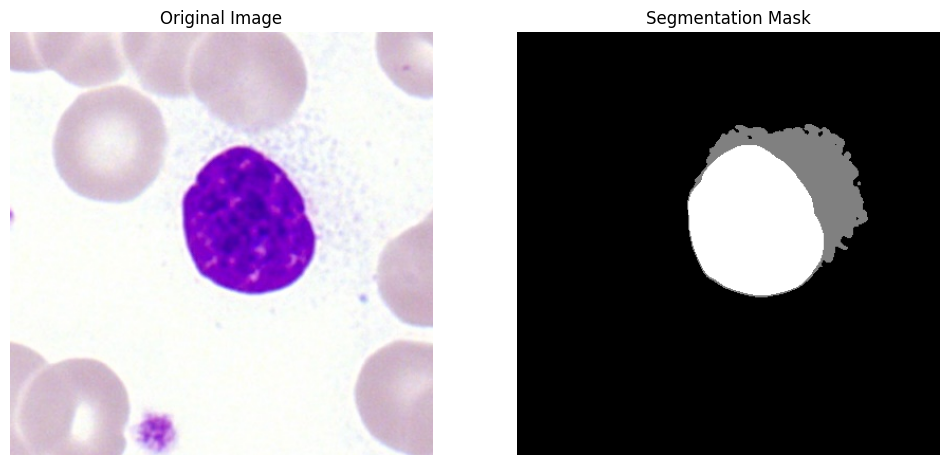

In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
from skimage import io
import matplotlib.pyplot as plt
import os

def inspect_segmentation_mask(mask_path, input_path):
    # if not os.path.exists(mask_path):
    #     print(f"Mask file not found: {mask_path}")
    #     return
    # if not os.path.exists(input_path):
    #     print(f"Input image file not found: {input_path}")
    #     return

    try:
        original_image = io.imread(input_path)
        mask = io.imread(mask_path)
    except Exception as e:
        print(f"Error reading images: {e}")

    # print(f"Original image shape: {original_image.shape}")
    # print(f"Mask shape: {mask.shape}")

    fig, ax = plt.subplots(1, 2, figsize=(12, 6))

    ax[0].imshow(original_image)
    ax[0].set_title('Original Image')
    ax[0].axis('off')

    ax[1].imshow(mask, cmap='gray')
    ax[1].set_title('Segmentation Mask')
    ax[1].axis('off')

    plt.show()

mask_path = '/content/drive/My Drive/MLQuiz-WangLab/nnUNet/nnUNet_transformer_results/Dataset555_BloodCellSeg/nnUNetTests/imagesTs-External-transformer/img_001.png'
input_path = '/content/drive/My Drive/MLQuiz-WangLab/nnUNet/nnUNet_raw/Dataset555_BloodCellSeg/imagesTs-External/img_001_0000.png'

inspect_segmentation_mask(mask_path, input_path)


In [ ]:
!nnUNetv2_predict -i '/content/drive/My Drive/MLQuiz-WangLab/nnUNet/nnUNet_raw/Dataset555_BloodCellSeg/imagesTr' -o '/content/drive/My Drive/MLQuiz-WangLab/nnUNet/nnUNet_transformer_results/Dataset555_BloodCellSeg/nnUNetTests/imagesTr' -d 555 -c "2d" --save_probabilities

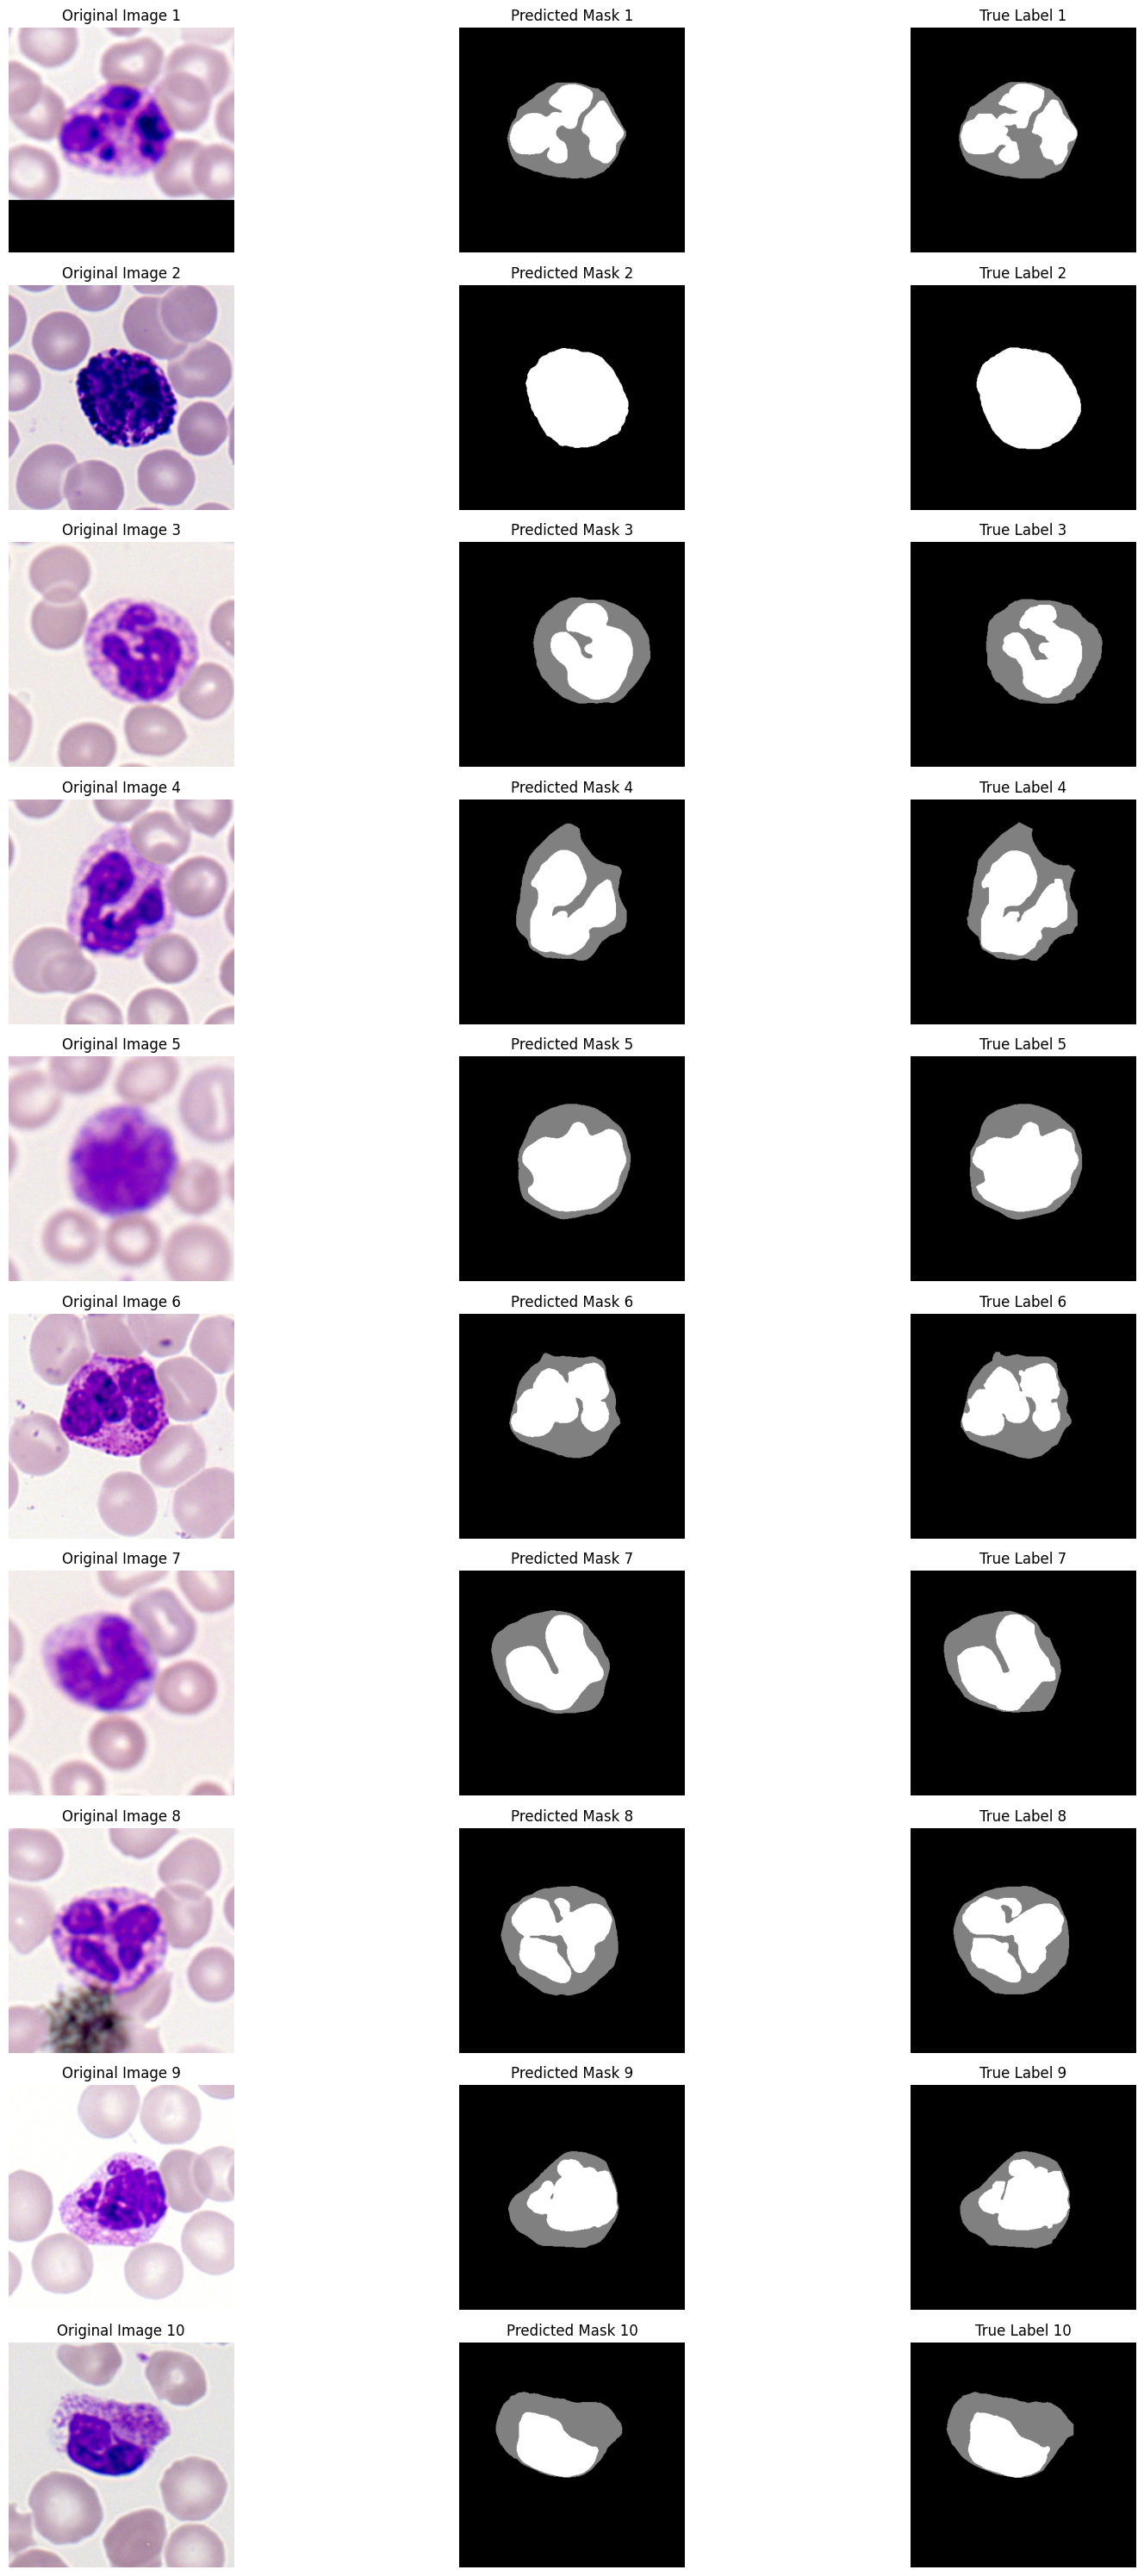

In [ ]:
import numpy as np
from skimage import io
import matplotlib.pyplot as plt
import os

def inspect_segmentation_masks(predicted_mask_paths, true_label_paths, input_paths):
    num_images = len(predicted_mask_paths)
    assert num_images == len(input_paths) == len(true_label_paths), "The number of paths must be the same for predicted masks, true labels, and input images"

    cols = 3
    rows = num_images

    fig, ax = plt.subplots(rows, cols, figsize=(18, rows * 3))

    for i in range(num_images):
        original_image = io.imread(input_paths[i])
        predicted_mask = io.imread(predicted_mask_paths[i])
        true_label = io.imread(true_label_paths[i])

        ax[i, 0].imshow(original_image, cmap='gray')
        ax[i, 0].set_title(f'Original Image {i+1}')
        ax[i, 0].axis('off')

        ax[i, 1].imshow(predicted_mask, cmap='gray')
        ax[i, 1].set_title(f'Predicted Mask {i+1}')
        ax[i, 1].axis('off')

        ax[i, 2].imshow(true_label, cmap='gray')
        ax[i, 2].set_title(f'True Label {i+1}')
        ax[i, 2].axis('off')

    plt.tight_layout()
    plt.show()

predicted_mask_folder = '/content/drive/My Drive/MLQuiz-WangLab/nnUNet/nnUNet_transformer_results/Dataset555_BloodCellSeg/nnUNetTests/imagesTr'
true_label_folder = '/content/drive/My Drive/MLQuiz-WangLab/nnUNet/nnUNet_raw/Dataset555_BloodCellSeg/labelsTr'
input_folder = '/content/drive/My Drive/MLQuiz-WangLab/nnUNet/nnUNet_raw/Dataset555_BloodCellSeg/imagesTr'

predicted_mask_files = [
    'img_000.png', 'img_001.png', 'img_002.png', 'img_003.png', 'img_004.png',
    'img_005.png', 'img_006.png', 'img_007.png', 'img_008.png', 'img_009.png'
]
true_label_files = [
    'img_000.png', 'img_001.png', 'img_002.png', 'img_003.png', 'img_004.png',
    'img_005.png', 'img_006.png', 'img_007.png', 'img_008.png', 'img_009.png'
]
input_files = [
    'img_000_0000.png', 'img_001_0000.png', 'img_002_0000.png', 'img_003_0000.png', 'img_004_0000.png',
    'img_005_0000.png', 'img_006_0000.png', 'img_007_0000.png', 'img_008_0000.png', 'img_009_0000.png'
]

predicted_mask_paths = [os.path.join(predicted_mask_folder, file) for file in predicted_mask_files]
true_label_paths = [os.path.join(true_label_folder, file) for file in true_label_files]
input_paths = [os.path.join(input_folder, file) for file in input_files]

inspect_segmentation_masks(predicted_mask_paths, true_label_paths, input_paths)


In [ ]:
predicted_mask_files = '/content/drive/My Drive/MLQuiz-WangLab/nnUNet/nnUNet_transformer_results/Dataset555_BloodCellSeg/nnUNetTests/imagesTr/img_010.png'
true_label_files = '/content/drive/My Drive/MLQuiz-WangLab/nnUNet/nnUNet_raw/Dataset555_BloodCellSeg/labelsTr/img_010.png'

!pip install medpy
from medpy import metric
from skimage import io

label_seg = io.imread(predicted_mask_files)
label_gt = io.imread(true_label_files)
whole_cell_dc = metric.binary.dc(label_seg>0, label_gt>0)
nucleus_dc = metric.binary.dc(label_seg==2, label_gt==2)

print(nucleus_dc)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.3/156.3 kB 10.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for medpy: filename=MedPy-0.5.2-cp310-cp310-linux_x86_64.whl size=762834 sha256=492ea727d9b506c6f159ee5c1cca506b3b9e0b44c445c063addee08c095f30fa
  Stored in directory: /root/.cache/pip/wheels/a1/b8/63/bdf557940ec60d1b8822e73ff9fbe7727ac19f009d46b5d175
Successfully built medpy
0.9815208352582463


In [ ]:
import os
import shutil

# Source directory containing the original files
source_dir = '/content/drive/My Drive/MLQuiz-WangLab/nnUNet/nnUNet_transformer_results/Dataset555_BloodCellSeg/nnUNetTests/imagesTs-Internal-transformer'
# Destination directory where the renamed files will be moved
destination_dir = '/content/drive/My Drive/MLQuiz-WangLab/nnUNet/nnUNet_transformer_results/Dataset555_BloodCellSeg/nnUNetTests/imagesTs-Internal-transformer-converted'

# Make sure the destination directory exists
os.makedirs(destination_dir, exist_ok=True)

# Iterate over all files in the source directory
for filename in os.listdir(source_dir):
    # Check if the file name matches the pattern 'img_xxx.png'
    if filename.startswith("img_") and filename.endswith(".png"):
        # Extract the numeric part
        numeric_part = filename.split('_')[1].split('.')[0]
        # Create the new file name
        new_filename = f"Internal_img_{numeric_part}_labels.png"
        # Construct the full file paths
        src_path = os.path.join(source_dir, filename)
        dest_path = os.path.join(destination_dir, new_filename)
        # Move and rename the file
        shutil.move(src_path, dest_path)

print("Files have been renamed and moved successfully.")


Files have been renamed and moved successfully.


In [ ]:
import os
import shutil

source_dir = '/content/drive/My Drive/MLQuiz-WangLab/nnUNet/nnUNet_transformer_results/Dataset555_BloodCellSeg/nnUNetTests/imagesTs-External-transformer'
destination_dir = '/content/drive/My Drive/MLQuiz-WangLab/nnUNet/nnUNet_transformer_results/Dataset555_BloodCellSeg/nnUNetTests/imagesTs-External-transformer-converted'

os.makedirs(destination_dir, exist_ok=True)

for filename in os.listdir(source_dir):
    if filename.startswith("img_") and filename.endswith(".png"):
        numeric_part = filename.split('_')[1].split('.')[0]
        new_filename = f"External_img_{numeric_part}_labels.png"
        src_path = os.path.join(source_dir, filename)
        dest_path = os.path.join(destination_dir, new_filename)
        shutil.move(src_path, dest_path)

print("Files have been renamed and moved successfully.")


Files have been renamed and moved successfully.


- Fine-tuning

In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10
model.train()

for epoch in range(num_epochs):
    running_loss = 0.0
    for images, masks in dataloader:
        images = images.to(device)
        masks = masks.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(dataloader):.4f}')

print('Finished Training')
